The Kayak explore feature uses google maps to display the cheapest flights to international airports across the world at any point within a specified time interval. You can leave the interval blank to find the cheapest flights possible, but in this case we are looking for a good deal within the next summer break (specifically, the beginning of June to the end of August). Our program first uses the python request library to scrape all of the flight data sent to google maps from kayak in JSON format. We then parse the JSON string to get the specific details we are interested in.

In [2]:
import requests, smtplib, os, datetime
import pandas as pd
from bs4 import *
import urllib.request as ur
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from matplotlib import pyplot as plt

# Specify the beginning and end of the time frame of possible dates as YYYYMMDD
timeframe_begin = 20200601
timeframe_end = 20200830

def scrape_kayak(start='', end='', airport = 'BER'):
    """
    This function scrapes flight information from the kayak explore page.
    
    Parameters:
    start, end, airport - integer representing earliest possible departure date
    in YYYYMMDD format, integer representing latest return date, string with 
    three letter code for starting airport. When both are start and end are 
    left blank, results are returned from present date to one year in the 
    future.
    
    Returns:
    df - a data frame containing all destination cities and corresponding 
    flight information returned by the scrape
    """

    # Format the beginning and end dates to insert them into the URL
    start = '&depart=' + str(start)
    end = '&return=' + str(end)
    
    url = "https://www.kayak.com/s/horizon/exploreapi/elasticbox?airport=" + airport + "&v=1" + start + end + \
    "&stopsFilterActive=false&duration=&budget=&topRightLat=68.58212830775821&topRightLon=180&bottomLeftLat=-6.168763628541718&bottomLeftLon=-180&zoomLevel=2"
    response = requests.post(url).json()

    df = pd.DataFrame(columns=['City', 'Country', 'Price', 'Airline', 'Airport', 'Date', 'Link'])
    
    for i in range(len(response['destinations'])):
        destination = response['destinations'][i]
        row = list([destination['city']['name'], destination['country']['name'], 
                    destination['flightInfo']['price'], destination['airline'],
                    destination['airport']['shortName'], pd.to_datetime(destination['departd']).date(),
                    str('http://kayak.com'+destination['clickoutUrl'])])
        df.loc[i] = row
        
    city_mins = df.groupby(['City']).idxmin().astype(int)
    df = df.loc[city_mins['Price'].to_list()]
    # There is a glitch where some flights are returned with unrealistically
    # high prices, so we'll remove those entries.
    df = df.where(df['Price']!=999999).dropna()
        
    return df

all_flights = scrape_kayak(timeframe_begin, timeframe_end)
all_flights.head()

,City,Country,Price,Airline,Airport,Date,Link
204,Abakan,Russia,418.0,Aeroflot,ABA,2020-07-08,http://kayak.com/flights/SXF-ABA/2020-07-08/20...
20,Aberdeen,United Kingdom,188.0,KLM,ABZ,2020-07-02,http://kayak.com/flights/TXL-ABZ/2020-07-02/20...
569,Abu Dhabi,United Arab Emirates,510.0,Multiple Airlines,AUH,2020-07-02,http://kayak.com/flights/TXL-AUH/2020-07-02/20...
53,Abuja,Nigeria,790.0,Turkish Airlines,ABV,2020-07-02,http://kayak.com/flights/TXL-ABV/2020-07-02/20...
106,Acapulco,Mexico,3593.0,Multiple Airlines,ACA,2020-07-02,http://kayak.com/flights/TXL-ACA/2020-07-02/20...


We have about 500 rows of flight information, so we really need a good way to summarize the data. Let's return a dataframe showing the cheapest flights from our destination to each continent. Unfortunately, the JSON string returned by Kayak doesn't specify the continent of each destination country, so let's scrape wikipedia to map countries to their respective continents.

In [3]:
def scrape_wikipedia():
    """
    This function scrapes and parses several wikipedia pages to map flight 
    destination cities to their respective continents. It then cleans the 
    resulting data frame.
    
    Returns:
    df - a data frame containing all cities from the wiki data and the
    continents where they are located
    """

    urls = ['https://en.wikipedia.org/wiki/List_of_African_countries_by_area',
           'https://en.wikipedia.org/wiki/List_of_North_American_countries_by_GDP_(nominal)_per_capita',
           'https://en.wikipedia.org/wiki/List_of_South_American_countries_by_population',
           'https://en.wikipedia.org/wiki/List_of_European_countries_by_area',
           'https://en.wikipedia.org/wiki/List_of_Oceanian_countries_by_population',
           'https://en.wikipedia.org/wiki/List_of_countries_in_Asia-Pacific_by_GDP_(nominal)',
           'https://en.wikipedia.org/wiki/List_of_Middle_Eastern_countries_by_population']
    
    #  We'll count the Middle East as Asia
    continents = ['Africa', 'North America', 'South America', 'Europe', 
                  'Oceania', 'Asia', 'Asia']    
    all_continents, countries = [], []
    df = pd.DataFrame(columns=['Country', 'Continent'])
    
    for i in range(len(urls)):
        html = ur.urlopen(urls[i]).read()
        soup = BeautifulSoup(html, 'html.parser') 
        table = soup.find_all('table')[0]  
        rows = table.find_all('tr')
        
        for row in rows:
            columns = row.find_all('td')
            if len(columns) > 0:
                country = columns[1].get_text().strip()
                if country not in countries:
                    countries.append(country)
                    all_continents.append(continents[i])            
    
    # Remove all parentheses
    countries = pd.Series(countries).replace(regex=True,
                         to_replace=[r'\d', r'\([^)]*\)', ''], value=r'')
    # Remove brackets and asterisks
    countries = countries.replace(regex=True,
                                  to_replace=[r'\[[^()]*\]', r'[\*]'],
                                  value=r'')
    df['Country'] = countries
    df['Continent'] = pd.Series(all_continents)
    
    return df

# If we've already run the scraper, there's no need to scrape wikipedia a
# second time.
if not os.path.isfile('data\continents.csv'):
    all_continents = scrape_wikipedia()
else:
    all_continents = pd.read_csv('data\continents.csv', index_col=0)
    
print(all_continents.head())

                            Country Continent
0                           Algeria    Africa
1  Democratic Republic of the Congo    Africa
2                             Sudan    Africa
3                             Libya    Africa
4                              Chad    Africa


Now that we have the continent for each country, let's find the best deal for each continent, and include two other regional destinations we are interested in to group alongside the continents (Japan and Hawaii).

In [5]:
def summarize_results(cities):
    """
    This function finds the lowest priced flight to each continent, as well as 
    to specific regions we're interested in, in this case Japan and Hawaii.
    
    Parameters:
    cities - a data frame with scraped kayak flight information with a 
    continent mapped to each city.
    
    Returns:
    deals - a data frame containing flight information for the cheapest flight
    to each destination of interest.
    """
    
    hi_airports = ['HNL', 'MKK', 'OGG', 'KOA', 'ITO']
    hawaii = cities[cities['Airport'].str.match('LIH')]
    
    # Create a dataframe with all of the Hawaii flights
    for airport in hi_airports:
        hawaii = hawaii.append(cities[cities['Airport'].str.match(airport)])
    
    # Doing the same for Japan is a bit easier since we can just grep the
    # country ccolumn
    japan = cities[cities['Country'].str.match('Japan')]
    jp_lowest = japan.loc[japan['Price'].idxmin()].copy()
    jp_lowest['Continent'] = 'Japan*' # Differentiate the Japan flights from Asia flights
    hi_lowest = hawaii.loc[hawaii['Price'].idxmin()].copy()
    hi_lowest['Continent'] = 'Hawaii*'
    lowest = cities.groupby(['Continent'])['Price'].idxmin()
    deals = cities.iloc[lowest,:]
    deals = deals.append(jp_lowest)
    deals = deals.append(hi_lowest)
    deals = deals.set_index('Continent')
    deals['Price']= deals['Price'].astype(int)
    deals['Price']= '$' + deals['Price'].astype(str)
    
    return deals

flights_list = all_flights.merge(all_continents, how='left', on='Country')
results = summarize_results(flights_list)
print(results.head())

                     City        Country Price            Airline Airport  \
Continent                                                                   
Africa          Marrakesh        Morocco  $135            easyJet     RAK   
Asia             Tel Aviv         Israel  $196            Ryanair     TLV   
Europe         Luxembourg     Luxembourg   $53            Ryanair     LUX   
North America      Newark  United States  $364  Multiple Airlines     EWR   
Oceania            Sydney      Australia  $726              Scoot     SYD   

                     Date                                               Link  
Continent                                                                     
Africa         2020-06-18  http://kayak.com/flights/SXF-RAK/2020-06-18/20...  
Asia           2020-07-27  http://kayak.com/flights/SXF-TLV/2020-07-27/20...  
Europe         2020-06-03  http://kayak.com/flights/TXL-LUX/2020-06-03/20...  
North America  2020-06-08  http://kayak.com/flights/TXL-EWR/2020-

Here is a function that determines whether or not to send an email based on the present results.

In [ ]:
def check_df(results, start, end):
    """
    This function compares the results of the current scrape with previous
    results to determine if an email update should be sent.
    
    Parameters: 
    results, start, end - dataframe with summarized scrape results, integer 
    representing earliest possible departure date in YYYYMMDD format, integer 
    representing latest return date
    
    Returns:
    msgs, email - list of strings indicating continents for which good deals are 
    available, boolean indicating whether an email should be sent
    """
    
    filename = 'data/' + str(start) + '_to_' + str(end) + '_kayak_scrape.csv'
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        df = pd.DataFrame(columns=['Date'])
        
    current_scrape = results['Price']
    
    # Append the current scrape as a row if it isn't a duplicate
    if df.append(current_scrape).drop([
            'Date'], axis=1).duplicated().any() == False:
        df = df.append(current_scrape)
        now = datetime.datetime.now()
        df.iloc[-1,0] = now
        df.index = range(len(df))

    df.to_csv(filename, index=False)
    msgs = ''
    # Bool indicating if an email will be sent. Will be set to true if good 
    # deals are detected
    email = False 
    # Percent of average flight price to a given destination; if a current price is 
    # under this threshold, an email alert will be generated
    email_threshold = 0.85

    for column in range(1,len(df.columns)):
        col_mean = df.iloc[:,column].mean()
        if col_mean * email_threshold > df.iloc[-1,column]:
            name = df.columns[column]
            msg = 'Flights to ' + name + ' right now are abnormally cheap.<br>'
            msgs += msg
            email = True
            
    print(df)
            
    return msgs, email

msgs, email = check_df(results, timeframe_begin, timeframe_end)
print(msgs)

This function sends an email if the current scrape has any outstanding deals to at least one of our destinations.

In [14]:
def send_email(flights):
    """
    This function sends an email with the summarized flight data as a data 
    frame in html to the specified address. 
    
    Parameters:
    flights - a dataframe of the best deals on flights and the corresponding 
    details returned by our scrape.
    """
    
    password = input('Type your password:')
    message = MIMEMultipart('alternative')
    message.add_header('Content-Type','html')
    sender = 'youremail@domain.com'
    receiver = 'theiremail@domain.com'
    message['Subject'] = "Here is your latest Kayak scrape!"
    message['From'] = sender
    message['To'] = receiver
    html = "<html><head></head><body><p>" + msgs + \
    flights.to_html() + ". </p></body></html>"
    
    part1 = MIMEText(html, 'html')
    message.attach(part1)
    mail = smtplib.SMTP('smtp.gmail.com', 587)
    mail.ehlo()
    mail.starttls()
    mail.login('your_username', password)
    mail.sendmail(sender, receiver.split(','), message.as_string())
    mail.quit() 

if email:
    #send_email(results)
    pass #  No email in this jupyter version

This function saves a dataframe with the data from all flights (not just the best deals), which is useful for producing some charts.

In [17]:

def save_scrape(flights, start, end):
    """
    This function appends a column containing all of the current scraped prices
    to a dataframe of saved flight price data.
    
    Parameters: 
    flights, start, end - dataframe with all scraped flight results, integer 
    representing earliest possible departure date in YYYYMMDD format, integer 
    representing latest return date
    
    Returns:
    dataframe containing all previously scraped flight data plus the current scrape
    """
    filename = 'data/' + str(start) + '_to_' + str(end) + '_all_flights.csv'
    now = datetime.datetime.now()
    current_prices = flights.set_index('City')['Price']
    current_prices.name = now
    
    if os.path.isfile(filename):
        df = pd.read_csv(filename, index_col=0)
        df = df.merge(current_prices, how='outer', left_index=True, 
                      right_index=True)
    else:
        df = pd.DataFrame(current_prices)
        df['Continent'] = flights_list.set_index('City')['Continent']
        
    df.to_csv(filename)
    
    return df.drop('Continent', axis=1).dropna()

historical = save_scrape(flights_list, timeframe_begin, timeframe_end)
print(historical.head())

           2019-09-11 22:05:24.869258  2019-09-12 09:01:14.631851  \
City                                                                
Aberdeen                        563.0                       188.0   
Abu Dhabi                       510.0                       510.0   
Abuja                          1877.0                      1878.0   
Acapulco                       2486.0                      2486.0   
Accra                           711.0                       711.0   

           2019-09-12 11:36:55.827211  2019-09-12 12:22:00.953972  \
City                                                                
Aberdeen                        188.0                       188.0   
Abu Dhabi                       510.0                       510.0   
Abuja                          1878.0                      1878.0   
Acapulco                       2486.0                      2486.0   
Accra                           709.0                       709.0   

           2019-09-12 12:23:51.2

This chart summarizes the distribution of prices to each continent from the current scrape.

Populating the interactive namespace from numpy and matplotlib


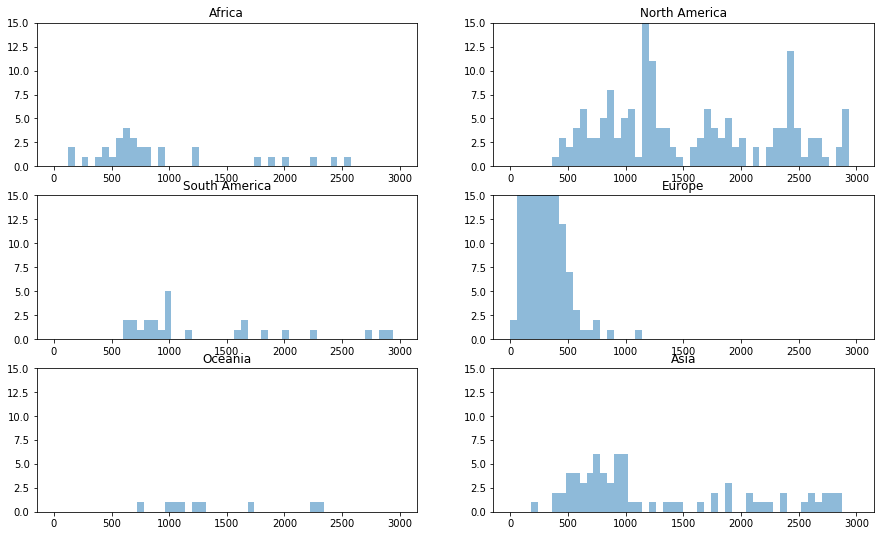

In [6]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

continents = ['Africa', 'North America', 'South America', 
              'Europe', 'Oceania', 'Asia']
plot_num = 1

for continent in continents:
    plt.subplot(3,2,plot_num)
    axes = plt.gca()
    axes.set_ylim([0,15])
    df = flights_list.where(flights_list['Continent']==continent).dropna()
    plt.hist(df['Price'], bins=50, alpha=0.5, range=(0,3000))
    title = plt.gca().set_title(continent)
    plot_num += 1
    
plt.show()

The next chart is possibly more useful, because it tells us which cities in our regional destinations have a wide variability in flight prices. Cities for which the boxes are long or have many outliers may be worth paying additional attention to.

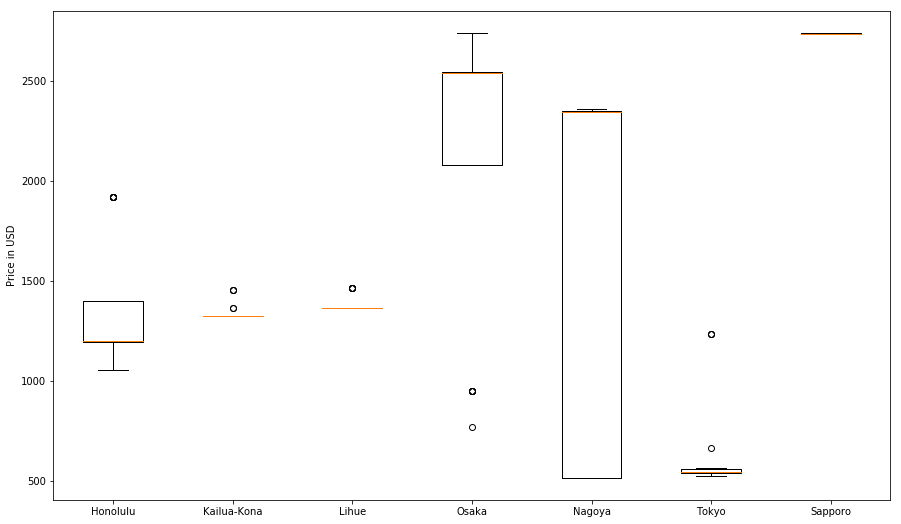

In [21]:
dest_prices, labels = [], []

# This lists cities from Hawaii and Japan to which flights are present in our
# data frame.
bp_cities = ['Honolulu', 'Kailua-Kona', 'Kahului', 'Lihue', 'Osaka', 'Nagoya', 
          'Tokyo', 'Sapporo', 'Okinawa']

for city in bp_cities:
        df = historical[historical.index.str.match(city)].T
        if df.shape[1] > 0:
            df = pd.Series(df[city]).tolist()
            dest_prices.append(df)
            labels.append(city)
        
fig, ax = plt.subplots()
ax.boxplot(dest_prices, labels=labels, whis=2)
plt.ylabel('Price in USD')
plt.show()